In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib as plt
import seaborn as sns
import os

In [4]:
df_train = pd.read_csv("/kaggle/input/hr-ana/train.csv")

In [62]:
df_test = pd.read_csv("/kaggle/input/hr-ana/test.csv")

In [6]:
df = df_train.copy()

In [9]:
print("Train shape:", df.shape)
print("Test shape:", df_test.shape)

Train shape: (54808, 13)
Test shape: (23490, 12)


In [7]:
df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0


In [8]:
folders = ['data', 'models', 'src', 'ui', 'api', 'logs']
for folder in folders:
    os.makedirs(f"/kaggle/working/{folder}", exist_ok=True)


##### Basic Data inspection

In [12]:
# Data types and missing values
df.info()

# How many unique values per column
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won?           54808 non-null  int64  
 11  avg_training_score    54808 non-null  int64  
 12  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 5.4+ MB


employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [13]:
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,54808.0,39195.830627,22586.581449,1.0,19669.75,39225.5,58730.5,78298.0
no_of_trainings,54808.0,1.253011,0.609264,1.0,1.00,1.0,1.0,10.0
age,54808.0,34.803915,7.660169,20.0,29.00,33.0,39.0,60.0
previous_year_rating,50684.0,3.329256,1.259993,1.0,3.00,3.0,4.0,5.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.00,5.0,7.0,37.0
awards_won?,54808.0,0.023172,0.150450,0.0,0.00,0.0,0.0,1.0
avg_training_score,54808.0,63.386750,13.371559,39.0,51.00,60.0,76.0,99.0
is_promoted,54808.0,0.085170,0.279137,0.0,0.00,0.0,0.0,1.0


#### Identify Categorical vs Numerical Columns

In [33]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols   = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)


Categorical Columns: ['department', 'region', 'education', 'gender', 'recruitment_channel']
Numerical Columns: ['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 'is_promoted']


In [14]:
# Percentage of missing values
missing = df.isnull().mean().sort_values(ascending=False) * 100
missing[missing > 0]

previous_year_rating    7.524449
education               4.395344
dtype: float64

### Outlier and Sanity checks
##### age should not be < 18 or > 65 -> if yes it's outlier
##### if length_of_service > age → data error
##### avg_training_score outside 0–100 → input mistake

In [18]:
df[['age', 'length_of_service', 'avg_training_score']].describe()

,age,length_of_service,avg_training_score
count,54808.000000,54808.000000,54808.000000
mean,34.803915,5.865512,63.386750
std,7.660169,4.265094,13.371559
min,20.000000,1.000000,39.000000
25%,29.000000,3.000000,51.000000
50%,33.000000,5.000000,60.000000
75%,39.000000,7.000000,76.000000
max,60.000000,37.000000,99.000000


In [28]:
df.loc[df['length_of_service'] > df['age'], 'length_of_service'] = np.nan

#### Target Distribution

In [16]:
df['is_promoted'].value_counts(normalize=True) * 100

is_promoted
0    91.482995
1     8.517005
Name: proportion, dtype: float64

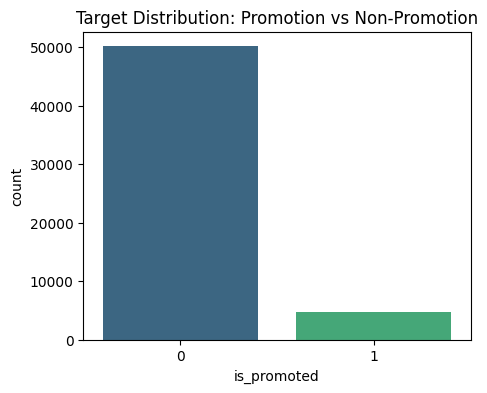

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x='is_promoted', data=df, palette='viridis')
plt.title('Target Distribution: Promotion vs Non-Promotion')
plt.show()

### The promotion target is highly imbalanced, so I’ll use stratified train-test split and handle imbalance via class weights rather than resampling

#### Univariate Analysis

#### Numeric Features

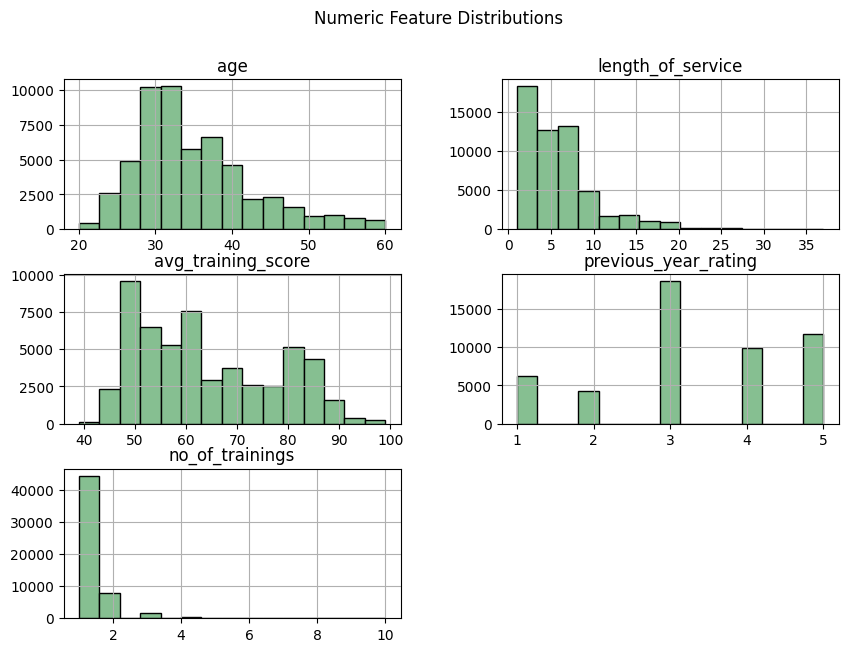

In [19]:
num_cols = ['age', 'length_of_service', 'avg_training_score', 'previous_year_rating', 'no_of_trainings']

df[num_cols].hist(figsize=(10,7), bins=15, color='#86bf91', edgecolor='black')
plt.suptitle("Numeric Feature Distributions")
plt.show()


Age: Most employees are between 25–40 years, showing a young workforce. No unrealistic ages found, and age doesn’t appear to have a strong direct link with promotion.

Length of Service: Majority have under 10 years of service, with a few long-tenure outliers up to 37 years. Tenure alone isn’t a major promotion driver, but we’ll cap extreme values.

Average Training Score: Scores range from 40–100, with higher scores clearly indicating stronger performance — a key factor likely affecting promotions.

Previous Year Rating: Ratings mostly 3–5, suggesting decent performance overall. Missing values (≈7.5%) likely belong to new hires and will be imputed. Strong correlation expected with promotion.

Number of Trainings: Most employees attended just one training; very few attended many. It shows limited variation, so its impact on promotion might be minimal

#### Categorical Features

In [29]:
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(normalize=True).head(10) * 100)



Column: department
department
Sales & Marketing    30.725442
Operations           20.705007
Technology           13.023646
Procurement          13.023646
Analytics             9.764998
Finance               4.627062
HR                    4.411765
Legal                 1.895709
R&D                   1.822727
Name: proportion, dtype: float64

Column: region
region
region_2     22.520435
region_22    11.728215
region_7      8.836301
region_15     5.123340
region_13     4.831411
region_26     4.123486
region_31     3.530506
region_4      3.107211
region_27     3.026930
region_16     2.672967
Name: proportion, dtype: float64

Column: education
education
Bachelor's          69.980343
Master's & above    28.483368
Below Secondary      1.536289
Name: proportion, dtype: float64

Column: gender
gender
m    70.237921
f    29.762079
Name: proportion, dtype: float64

Column: recruitment_channel
recruitment_channel
other       55.550285
sourcing    42.366078
referred     2.083637
Name: proportion, 

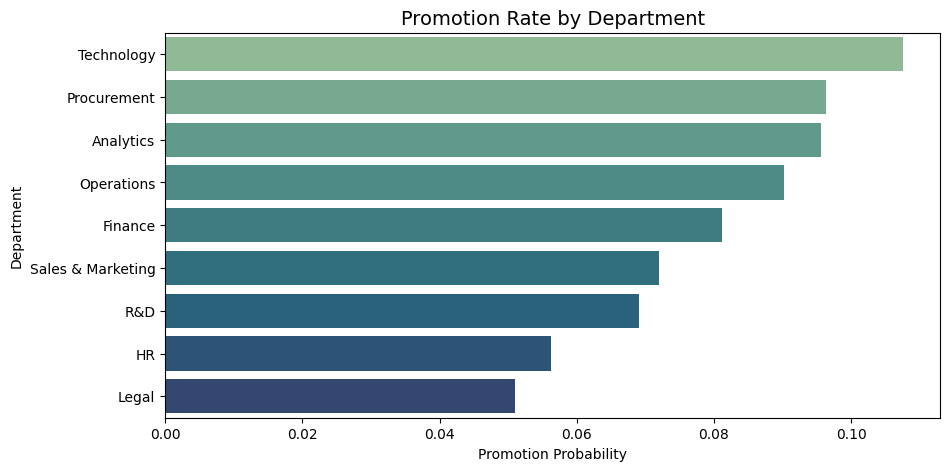

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
dept_promo = df.groupby('department')['is_promoted'].mean().sort_values(ascending=False).reset_index()

sns.barplot(x='is_promoted', y='department', data=dept_promo, palette='crest')
plt.title('Promotion Rate by Department', fontsize=14)
plt.xlabel('Promotion Probability')
plt.ylabel('Department')
plt.show()


#### Technology, Procurement, and Analytics have noticeably higher promotion probabilities, implying that promotion criteria differ by department. This justifies treating department as a significant categorical variable and analysing its interaction with performance-based metrics in modelling

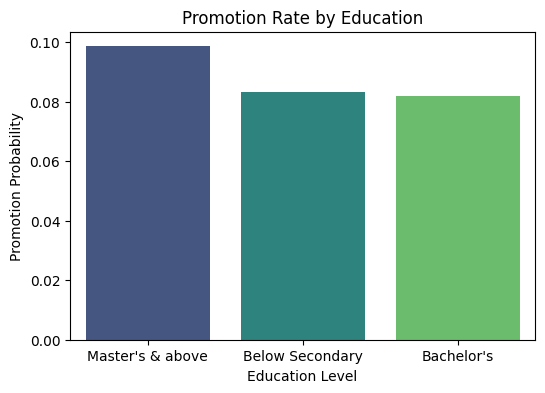

In [37]:
plt.figure(figsize=(6,4))
edu_promo = df.groupby('education')['is_promoted'].mean().sort_values(ascending=False).reset_index()

sns.barplot(x='education', y='is_promoted', data=edu_promo, palette='viridis')
plt.title('Promotion Rate by Education')
plt.ylabel('Promotion Probability')
plt.xlabel('Education Level')
plt.show()


#### The chart shows that employees with Master’s or higher education have the highest promotion probability (≈10%), slightly above those with Bachelor’s or Below Secondary education levels (~8–8.5%). This suggests that higher education correlates modestly with career advancement. However, since the gap is small, education alone isn’t a dominant promotion factor, it likely interacts with performance indicators such as training scores and prior ratings

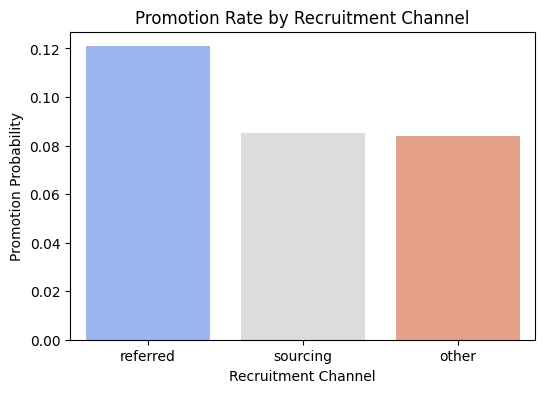

In [32]:
plt.figure(figsize=(6,4))
rec_promo = df.groupby('recruitment_channel')['is_promoted'].mean().sort_values(ascending=False).reset_index()

sns.barplot(x='recruitment_channel', y='is_promoted', data=rec_promo, palette='coolwarm')
plt.title('Promotion Rate by Recruitment Channel')
plt.ylabel('Promotion Probability')
plt.xlabel('Recruitment Channel')
plt.show()


#### Employees hired through referrals have the highest promotion rate, around 12 percent, suggesting they adapt faster or perform better due to stronger organisational fit. Those recruited through sourcing or other channels show lower rates, about 8 to 9 percent, indicating that recruitment source has a small but notable influence on promotion outcomes

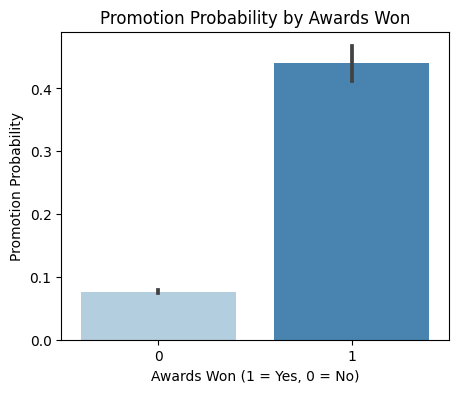

In [33]:
plt.figure(figsize=(5,4))
sns.barplot(x='awards_won?', y='is_promoted', data=df, palette='Blues')
plt.title('Promotion Probability by Awards Won')
plt.ylabel('Promotion Probability')
plt.xlabel('Awards Won (1 = Yes, 0 = No)')
plt.show()


#### Employees who have won awards show a much higher promotion probability, around 45 percent, compared to only about 7 percent for those without awards. This indicates that receiving an award is a strong indicator of high performance and significantly boosts the chances of promotion.

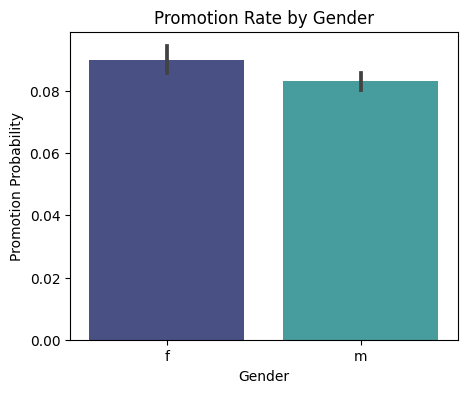

In [34]:
plt.figure(figsize=(5,4))
sns.barplot(x='gender', y='is_promoted', data=df, palette='mako')
plt.title('Promotion Rate by Gender')
plt.ylabel('Promotion Probability')
plt.xlabel('Gender')
plt.show()


#### The promotion rates for both genders are quite close, with females showing a slightly higher probability of promotion at around 9 percent compared to about 8 percent for males. This suggests that promotions appear largely gender-neutral, with no major bias evident in the dataset

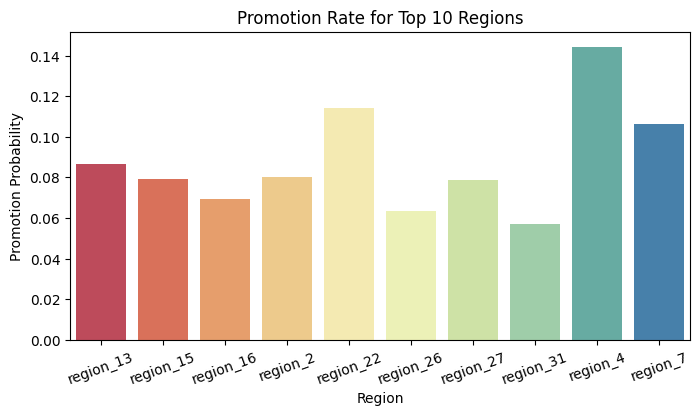

In [39]:
top_regions = df['region'].value_counts().head(10).index
region_promo = df[df['region'].isin(top_regions)].groupby('region')['is_promoted'].mean().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x='region', y='is_promoted', data=region_promo, palette='Spectral')
plt.title('Promotion Rate for Top 10 Regions')
plt.ylabel('Promotion Probability')
plt.xlabel('Region')
plt.xticks(rotation=20)
plt.show()


##### Promotion rates vary noticeably across regions, ranging roughly from 6 to 14 percent. Regions such as region_4 and region_22 show the highest promotion probabilities, while region_26 and region_31 have the lowest. This suggests that promotion opportunities may differ by regional office or workforce composition, though the variation is moderate and likely influenced by department and role mix within each region

In [ ]:
# =========================
# Categorical EDA Visuals
# =========================
''' import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Uncomment if you haven't loaded yet:
# data_path = "/kaggle/input/hr-analytics-job-prediction/"
# df = pd.read_csv(os.path.join(data_path, "train.csv"))

# Keep only needed columns
df = df[['department','region','education','gender','recruitment_channel','awards_won?','is_promoted']].copy()

# For readability in plots
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

def plot_rate_bar(series_name, title=None, xlabel="Promotion Probability", ylabel=None, top_n=None, order_desc=True):
    """Generic helper to plot promotion rate by a categorical column."""
    tmp = (
        df.groupby(series_name)['is_promoted']
        .mean()
        .sort_values(ascending=not order_desc)
        .reset_index()
        .rename(columns={'is_promoted':'promotion_rate'})
    )
    if top_n:
        tmp = tmp.head(top_n)

    plt.figure(figsize=(9, 4 + 0.22*len(tmp)))
    sns.barplot(
        data=tmp,
        x='promotion_rate',
        y=series_name,
        orient='h'
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel if ylabel is not None else series_name)
    plt.title(title if title else f'Promotion Rate by {series_name}')
    # Show values on bars
    for i, v in enumerate(tmp['promotion_rate']):
        plt.text(v + 0.002, i, f"{v:.3f}", va='center')
    plt.tight_layout()
    plt.show()

# 1) Department
plot_rate_bar('department', title='Promotion Rate by Department')

# 2) Education
plot_rate_bar('education', title='Promotion Rate by Education', order_desc=True)

# 3) Recruitment Channel
plot_rate_bar('recruitment_channel', title='Promotion Rate by Recruitment Channel', order_desc=True)

# 4) Awards (binary but highly predictive)
plt.figure(figsize=(6,4))
awards_rate = (
    df.groupby('awards_won?')['is_promoted']
    .mean()
    .reset_index()
    .rename(columns={'is_promoted':'promotion_rate'})
)
sns.barplot(data=awards_rate, x='awards_won?', y='promotion_rate')
plt.title('Promotion Probability by Awards Won')
plt.xlabel('Awards Won (1 = Yes, 0 = No)')
plt.ylabel('Promotion Probability')
for i, v in enumerate(awards_rate['promotion_rate']):
    plt.text(i, v + 0.002, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

# 5) Gender (fairness slice)
plt.figure(figsize=(6,4))
gender_rate = (
    df.groupby('gender')['is_promoted']
    .mean()
    .reset_index()
    .rename(columns={'is_promoted':'promotion_rate'})
)
sns.barplot(data=gender_rate, x='gender', y='promotion_rate')
plt.title('Promotion Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Promotion Probability')
for i, v in enumerate(gender_rate['promotion_rate']):
    plt.text(i, v + 0.002, f"{v:.3f}", ha='center')
plt.tight_layout()
plt.show()

# 6) Region — Top 10 by headcount (avoid long-tail clutter)
top_regions = df['region'].value_counts().head(10).index
top_region_rate = (
    df[df['region'].isin(top_regions)]
    .groupby('region')['is_promoted'].mean()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'is_promoted':'promotion_rate'})
)
plt.figure(figsize=(9,5))
sns.barplot(data=top_region_rate, x='promotion_rate', y='region', orient='h')
plt.title('Promotion Rate by Region (Top 10 by Headcount)')
plt.xlabel('Promotion Probability')
plt.ylabel('Region')
for i, v in enumerate(top_region_rate['promotion_rate']):
    plt.text(v + 0.002, i, f"{v:.3f}", va='center')
plt.tight_layout()
plt.show()'''


### Train Test Split and Feature Engineering 

#### Pre Processing Pipeline

In [50]:
import pandas as pd
import numpy as np

cat_low = ["department","education","gender","recruitment_channel","awards_won?"]
num_base = ["age","length_of_service","avg_training_score","previous_year_rating","no_of_trainings"]

class SimplePreprocessor:
    def fit(self, X: pd.DataFrame):
        X = X.copy()
        # education mode (use 'Unknown' fallback)
        self.edu_mode_ = X["education"].mode(dropna=True)[0] if X["education"].notna().any() else "Unknown"
        # previous_year_rating
        self.prev_med_ = X["previous_year_rating"].median()
        # caps (winsor)
        self.cap_service_   = X["length_of_service"].quantile(0.99)
        self.cap_trainings_ = X["no_of_trainings"].quantile(0.99)
        # region frequency map
        self.region_freq_ = X["region"].value_counts().to_dict()
        # one-hot columns for small categoricals
        tmp = pd.get_dummies(X[cat_low].fillna({"education": self.edu_mode_}), drop_first=False)
        self.ohe_cols_ = tmp.columns.tolist()
        # final feature order
        self.num_cols_ = num_base + ["prev_rating_missing","region_freq"]
        self.feature_order_ = self.num_cols_ + self.ohe_cols_
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        # fill education
        X["education"] = X["education"].fillna(self.edu_mode_)
        # prev rating flag + median
        X["prev_rating_missing"] = X["previous_year_rating"].isna().astype(int)
        X["previous_year_rating"] = X["previous_year_rating"].fillna(self.prev_med_)
        # caps
        X["length_of_service"] = np.clip(X["length_of_service"], None, self.cap_service_)
        X["no_of_trainings"]   = np.clip(X["no_of_trainings"],   None, self.cap_trainings_)
        # region frequency
        X["region_freq"] = X["region"].map(self.region_freq_).fillna(0).astype(float)
        # one-hot for small categoricals, align to training columns
        ohe = pd.get_dummies(X[cat_low], drop_first=False)
        ohe = ohe.reindex(columns=self.ohe_cols_, fill_value=0)
        # numeric block
        num_block = X[self.num_cols_]
        out = pd.concat([num_block.reset_index(drop=True),
                         ohe.reset_index(drop=True)], axis=1)
        # ensure column order is stable
        return out[self.feature_order_]


### Split and preprocess, apply transformations

In [51]:
from sklearn.model_selection import train_test_split

TARGET = "is_promoted"
ID_COL = "employee_id"
use_cols = cat_low + ["region"] + num_base + [TARGET, ID_COL]

df = df_train[use_cols].copy()
X = df.drop(columns=[TARGET, ID_COL])
y = df[TARGET].astype(int)

X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

prep = SimplePreprocessor().fit(X_tr)
Xtr_proc = prep.transform(X_tr)
Xva_proc = prep.transform(X_va)


### Models (LR, Random Forest, XGBoost, LightGBM)

In [52]:
# Logistic Regression (needs scaling)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler(with_mean=False)
Xtr_lr = scaler.fit_transform(Xtr_proc)
Xva_lr = scaler.transform(Xva_proc)
logreg = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1).fit(Xtr_lr, y_tr)

# Random Forest / XGB / LGBM (no scaling)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgb

rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=2, n_jobs=-1,
                            class_weight="balanced_subsample", random_state=42).fit(Xtr_proc, y_tr)

spw = (len(y_tr) - y_tr.sum()) / max(y_tr.sum(), 1)
xgbm = xgb.XGBClassifier(n_estimators=600, max_depth=4, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                         objective="binary:logistic", eval_metric="aucpr",
                         tree_method="hist", random_state=42, scale_pos_weight=spw, n_jobs=-1).fit(Xtr_proc, y_tr)

lgbm = lgb.LGBMClassifier(n_estimators=800, num_leaves=31, learning_rate=0.05,
                          subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                          random_state=42).fit(Xtr_proc, y_tr)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3734, number of negative: 40112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 43846, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085162 -> initscore=-2.374195
[LightGBM] [Info] Start training from score -2.374195


#### CATBoost

In [53]:
from catboost import CatBoostClassifier, Pool
import numpy as np

def catboost_frame(X_):
    X_ = X_.copy()
    X_["education"] = X_["education"].fillna(prep.edu_mode_)
    X_["prev_rating_missing"] = X_["previous_year_rating"].isna().astype(int)
    X_["previous_year_rating"] = X_["previous_year_rating"].fillna(prep.prev_med_)
    X_["length_of_service"] = np.clip(X_["length_of_service"], None, prep.cap_service_)
    X_["no_of_trainings"]   = np.clip(X_["no_of_trainings"],   None, prep.cap_trainings_)
    feats = ["department","region","education","gender","recruitment_channel","awards_won?"] + \
            ["age","length_of_service","avg_training_score","previous_year_rating","no_of_trainings","prev_rating_missing"]
    return X_[feats]

cb_tr = catboost_frame(X_tr)
cb_va = catboost_frame(X_va)

cat_cols = ["department","region","education","gender","recruitment_channel","awards_won?"]
cb = CatBoostClassifier(iterations=800, depth=6, learning_rate=0.05,
                        loss_function="Logloss", eval_metric="AUC",
                        auto_class_weights="Balanced", random_state=42, verbose=False)
cb.fit(Pool(cb_tr, y_tr, cat_features=cat_cols),
       eval_set=Pool(cb_va, y_va, cat_features=cat_cols), verbose=False)


### Evaluation

In [54]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, classification_report

def report(model, Xv, yv, name):
    proba = model.predict_proba(Xv)[:,1]
    pred = (proba >= 0.5).astype(int)
    print(f"\n{name}")
    print(f"PR-AUC {average_precision_score(yv, proba):.4f} | ROC-AUC {roc_auc_score(yv, proba):.4f} | F1 {f1_score(yv, pred):.4f}")
    print(classification_report(yv, pred, digits=3))

report(logreg, Xva_lr, y_va, "Logistic Regression")
report(rf,     Xva_proc, y_va, "Random Forest")
report(xgbm,   Xva_proc, y_va, "XGBoost")
report(lgbm,   Xva_proc, y_va, "LightGBM")

cb_proba = cb.predict_proba(cb_va)[:,1]
cb_pred  = (cb_proba >= 0.5).astype(int)
print("\nCatBoost")
print(f"PR-AUC {average_precision_score(y_va, cb_proba):.4f} | ROC-AUC {roc_auc_score(y_va, cb_proba):.4f} | F1 {f1_score(y_va, cb_pred):.4f}")
print(classification_report(y_va, cb_pred, digits=3))



Logistic Regression
PR-AUC 0.5101 | ROC-AUC 0.7876 | F1 0.3156
              precision    recall  f1-score   support

           0      0.961     0.762     0.850     10028
           1      0.207     0.666     0.316       934

    accuracy                          0.754     10962
   macro avg      0.584     0.714     0.583     10962
weighted avg      0.897     0.754     0.804     10962


Random Forest
PR-AUC 0.5027 | ROC-AUC 0.7932 | F1 0.4775
              precision    recall  f1-score   support

           0      0.944     0.983     0.963     10028
           1      0.675     0.369     0.478       934

    accuracy                          0.931     10962
   macro avg      0.809     0.676     0.720     10962
weighted avg      0.921     0.931     0.922     10962


XGBoost
PR-AUC 0.5622 | ROC-AUC 0.8215 | F1 0.3814
              precision    recall  f1-score   support

           0      0.960     0.849     0.901     10028
           1      0.276     0.618     0.381       934

    accu

In [55]:
from sklearn.metrics import average_precision_score

scores = {
    "logreg": average_precision_score(y_va, logreg.predict_proba(Xva_lr)[:,1]),
    "rf":     average_precision_score(y_va, rf.predict_proba(Xva_proc)[:,1]),
    "xgb":    average_precision_score(y_va, xgbm.predict_proba(Xva_proc)[:,1]),
    "lgbm":   average_precision_score(y_va, lgbm.predict_proba(Xva_proc)[:,1]),
    "cat":    average_precision_score(y_va, cb.predict_proba(cb_va)[:,1]),
}
scores

{'logreg': 0.5100771302000162,
 'rf': 0.5026726485857156,
 'xgb': 0.5622165098578181,
 'lgbm': 0.5582799323670016,
 'cat': 0.5621313107294323}

In [56]:
# STEP 1 — Tune LightGBM with PR-AUC (Stratified 5-fold)

import numpy as np
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, classification_report

# Param space (tight, sensible)
lgb_space = {
    "n_estimators":       [400, 600, 800, 1200],
    "learning_rate":      [0.03, 0.05, 0.08, 0.1],
    "num_leaves":         [15, 31, 63],
    "min_child_samples":  [20, 50, 100],
    "subsample":          [0.7, 0.85, 1.0],
    "colsample_bytree":   [0.6, 0.8, 1.0],
    "reg_lambda":         [0.0, 0.5, 1.0, 2.0],
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgb_base = lgb.LGBMClassifier(
    objective="binary",
    random_state=42,
    # class_weight not set — boosters handle imbalance via trees; we’ll tune threshold later
)

rs = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=lgb_space,
    n_iter=30,
    scoring="average_precision",   # PR-AUC
    cv=cv5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Xtr_proc, y_tr, Xva_proc, y_va come from your simple preprocessor step
rs.fit(Xtr_proc, y_tr)
lgb_best = rs.best_estimator_
print("Best CV PR-AUC:", rs.best_score_)
print("Best params:", rs.best_params_)

# Holdout evaluation
proba = lgb_best.predict_proba(Xva_proc)[:, 1]
pred  = (proba >= 0.5).astype(int)
print(f"Holdout PR-AUC: {average_precision_score(y_va, proba):.4f} | ROC-AUC: {roc_auc_score(y_va, proba):.4f} | F1: {f1_score(y_va, pred):.4f}")
print(classification_report(y_va, pred, digits=3))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2988, number of negative: 32089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 35077, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085184 -> initscore=-2.373909
[LightGBM] [Info] Start training from score -2.373909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [57]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, roc_auc_score

# get predicted probabilities
y_proba = lgb_best.predict_proba(Xva_proc)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_va, y_proba)
thresholds = np.append(thresholds, 1.0)

# pick best threshold by F1 or target positive rate
def pick_threshold(y_true, y_prob, target_rate=None):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    thresholds = np.append(thresholds, 1.0)

    if target_rate:
        rates = [(y_prob >= t).mean() for t in thresholds]
        idx = np.argmin(np.abs(np.array(rates) - target_rate))
        return thresholds[idx]

    f1s = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
    return thresholds[np.argmax(f1s)]

# Option A: F1-optimal threshold
thr_f1 = pick_threshold(y_va, y_proba)
# Option B: match historical promotion rate (~9%)
thr_hist = pick_threshold(y_va, y_proba, target_rate=y_va.mean())

print(f"F1-optimal threshold: {thr_f1:.3f}")
print(f"Threshold matching historical promotion rate: {thr_hist:.3f}")

# Evaluate both thresholds
for name, thr in [("F1-optimal", thr_f1), ("Historical rate", thr_hist)]:
    pred = (y_proba >= thr).astype(int)
    f1 = f1_score(y_va, pred)
    print(f"\n{name} -> Threshold={thr:.3f} | F1={f1:.4f}")


F1-optimal threshold: 0.246
Threshold matching historical promotion rate: 0.159

F1-optimal -> Threshold=0.246 | F1=0.5356

Historical rate -> Threshold=0.159 | F1=0.4968

[LightGBM] [Info] Number of positive: 2987, number of negative: 32090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 35077, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085156 -> initscore=-2.374275
[LightGBM] [Info] Start training from score -2.374275
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2987, number of negative: 32090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011078 seconds.
You can set `force

In [58]:
# STEP 3 — Retrain final LightGBM on all training data with best params
import lightgbm as lgb
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, classification_report

# Merge full data
X_full = pd.concat([Xtr_proc, Xva_proc], axis=0)
y_full = pd.concat([y_tr, y_va], axis=0)

# Reuse tuned parameters
final_params = {
    "subsample": 0.7,
    "reg_lambda": 2.0,
    "num_leaves": 15,
    "n_estimators": 600,
    "min_child_samples": 50,
    "learning_rate": 0.03,
    "colsample_bytree": 0.6,
    "objective": "binary",
    "random_state": 42,
}

final_lgbm = lgb.LGBMClassifier(**final_params)
final_lgbm.fit(X_full, y_full)

# Save threshold for inference
FINAL_THRESHOLD = 0.246   # choose 0.246 (F1-optimal) unless you prefer matching rate
print("Final threshold set to:", FINAL_THRESHOLD)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4668, number of negative: 50140
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 207
[LightGBM] [Info] Number of data points in the train set: 54808, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085170 -> initscore=-2.374088
[LightGBM] [Info] Start training from score -2.374088
Final threshold set to: 0.246


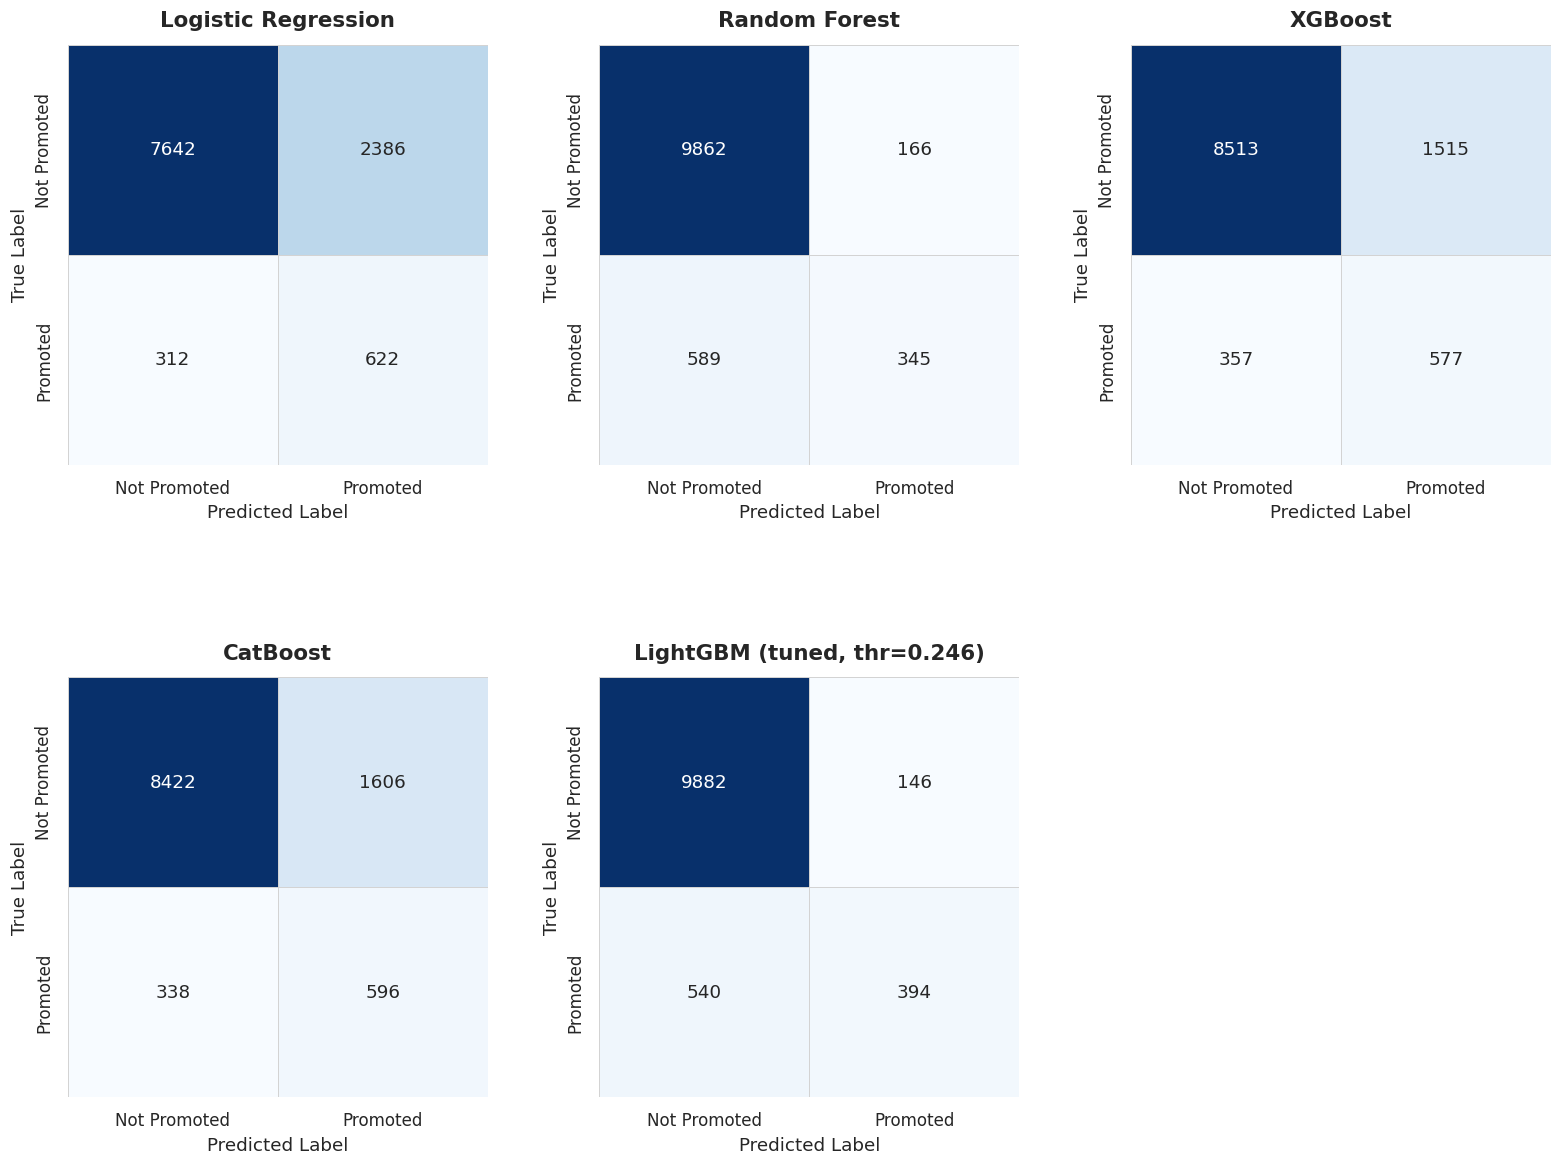

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Helper for predictions
def get_preds(model, X, y_true, threshold=0.5, needs_scaler=False):
    if needs_scaler:
        X = scaler.transform(X)
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, preds)
    return cm

# Model list
models_info = [
    ("Logistic Regression", logreg, Xva_proc, 0.5, True),
    ("Random Forest", rf, Xva_proc, 0.5, False),
    ("XGBoost", xgbm, Xva_proc, 0.5, False),
    ("CatBoost", cb, cb_va, 0.5, False),
    ("LightGBM (tuned, thr=0.246)", lgb_best, Xva_proc, 0.246, False),
]

# Bigger figure (2 rows × 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
axes = axes.flatten()

for i, (name, model, Xv, thr, scale_flag) in enumerate(models_info):
    # get confusion matrix
    if name.startswith("CatBoost"):
        proba = model.predict_proba(cb_va)[:, 1]
        preds = (proba >= thr).astype(int)
        cm = confusion_matrix(y_va, preds)
    else:
        cm = get_preds(model, Xv, y_va, thr, scale_flag)
    
    # plot as heatmap (cleaner than sklearn's default)
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", cbar=False,
        xticklabels=["Not Promoted", "Promoted"],
        yticklabels=["Not Promoted", "Promoted"],
        ax=axes[i], linewidths=0.5, linecolor="lightgray", square=True
    )
    axes[i].set_title(name, fontsize=14, fontweight="bold", pad=12)
    axes[i].set_xlabel("Predicted Label", fontsize=12)
    axes[i].set_ylabel("True Label", fontsize=12)

# Hide extra subplot (since we have 5 models)
for j in range(len(models_info), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()


### Save the final fine tuned model

In [60]:
import joblib, json, os

# create folder
os.makedirs("/kaggle/working/models", exist_ok=True)

# save model and preprocessor
joblib.dump(final_lgbm, "/kaggle/working/models/final_lgbm_model.joblib")
joblib.dump(prep, "/kaggle/working/models/preprocessor.joblib")

# save threshold as small text/json
with open("/kaggle/working/models/decision_threshold.json", "w") as f:
    json.dump({"threshold": float(FINAL_THRESHOLD)}, f)

print("Model, preprocessor, and threshold saved.")


Model, preprocessor, and threshold saved.


### Test on Original test set

In [64]:
# prepare test data using the saved preprocessor
test_raw = df_test[cat_low + ["region"] + num_base].copy()
Xtest_proc = prep.transform(test_raw)

# generate probabilities
test_proba = final_lgbm.predict_proba(Xtest_proc)[:, 1]

# apply chosen threshold
test_pred = (test_proba >= FINAL_THRESHOLD).astype(int)

# create submission-style dataframe (optional)
sub = pd.DataFrame({
    "employee_id": df_test["employee_id"],
    "is_promoted": test_pred
})
sub.head()


,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [77]:
# RUN in notebook ONCE
'''import json, os

state = {
    "edu_mode": prep.edu_mode_,
    "prev_med": float(prep.prev_med_),
    "cap_service": float(prep.cap_service_),
    "cap_trainings": float(prep.cap_trainings_),
    "region_freq": prep.region_freq_,                 # dict[str,int]
    "ohe_cols": prep.ohe_cols_,                       # list[str]
    "num_cols": prep.num_cols_,                       # list[str]
    "feature_order": prep.feature_order_,             # list[str]
    "cat_low": ["department","education","gender","recruitment_channel","awards_won?"],
    "num_base": ["age","length_of_service","avg_training_score","previous_year_rating","no_of_trainings"],
}
os.makedirs("/kaggle/working/models", exist_ok=True)
with open("/kaggle/working/models/preprocessor_state.json","w") as f:
    json.dump(state, f)
print("preprocessor_state.json saved")'''


preprocessor_state.json saved


In [78]:
'''import shutil, os

src_dir = "/kaggle/working/models"
dst_dir = "/kaggle/working/api/models"
os.makedirs(dst_dir, exist_ok=True)

for fname in ["final_lgbm_model.joblib",
              "preprocessor_state.json",
              "decision_threshold.json"]:
    shutil.copy(os.path.join(src_dir, fname),
                os.path.join(dst_dir, fname))

print("Files copied successfully!")'''


Files copied successfully!


In [85]:
%%bash
set -e
mkdir -p /kaggle/working/api

cat > /kaggle/working/api/app.py <<'PYCODE'
from fastapi import FastAPI
from pydantic import BaseModel, Field, ConfigDict
from typing import List, Optional
import pandas as pd
import numpy as np
import joblib, json, os
from fastapi.middleware.cors import CORSMiddleware

app = FastAPI(title="Employee Promotion Predictor", version="1.0.0")

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"], allow_credentials=True,
    allow_methods=["*"], allow_headers=["*"],
)

ART_DIR = "./models"
MODEL_PATH = os.path.join(ART_DIR, "final_lgbm_model.joblib")
THRESH_PATH = os.path.join(ART_DIR, "decision_threshold.json")
STATE_PATH = os.path.join(ART_DIR, "preprocessor_state.json")

model = joblib.load(MODEL_PATH)
with open(THRESH_PATH) as f:
    DECISION_THRESHOLD = float(json.load(f)["threshold"])
with open(STATE_PATH) as f:
    STATE = json.load(f)

CAT_LOW = STATE["cat_low"]
NUM_BASE = STATE["num_base"]

def preprocess_df(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()
    df["education"] = df["education"].fillna(STATE["edu_mode"])
    df["prev_rating_missing"] = df["previous_year_rating"].isna().astype(int)
    df["previous_year_rating"] = df["previous_year_rating"].fillna(STATE["prev_med"])
    df["length_of_service"] = np.clip(df["length_of_service"], None, STATE["cap_service"])
    df["no_of_trainings"] = np.clip(df["no_of_trainings"], None, STATE["cap_trainings"])
    df["region_freq"] = df["region"].map(STATE["region_freq"]).fillna(0).astype(float)
    ohe = pd.get_dummies(df[CAT_LOW], drop_first=False)
    ohe = ohe.reindex(columns=STATE["ohe_cols"], fill_value=0)
    num_block = df[STATE["num_cols"]]
    out = pd.concat([num_block.reset_index(drop=True), ohe.reset_index(drop=True)], axis=1)
    return out[STATE["feature_order"]]

class EmployeeRecord(BaseModel):
    model_config = ConfigDict(populate_by_name=True)

    employee_id: Optional[int] = None
    department: str
    region: str
    education: Optional[str] = None
    gender: str
    recruitment_channel: str
    awards_won_: int = Field(..., alias="awards_won?")
    age: int
    length_of_service: int
    avg_training_score: float
    previous_year_rating: Optional[float] = None
    no_of_trainings: int

class PredictRequest(BaseModel):
    records: List[EmployeeRecord]

@app.post("/predict")
def predict(req: PredictRequest):
    df = pd.DataFrame([r.model_dump(by_alias=True) for r in req.records])
    for col in (CAT_LOW + ["region"] + NUM_BASE):
        if col not in df.columns:
            df[col] = np.nan
    X = preprocess_df(df)
    proba = model.predict_proba(X)[:, 1]
    pred = (proba >= DECISION_THRESHOLD).astype(int)
    results = []
    for i in range(len(df)):
        results.append({
            "employee_id": None if pd.isna(df.loc[i, "employee_id"]) else int(df.loc[i, "employee_id"]),
            "probability": float(proba[i]),
            "prediction": int(pred[i]),
        })
    return {"threshold": DECISION_THRESHOLD, "results": results}

@app.get("/health")
def health():
    return {"status": "ok", "model_loaded": os.path.exists(MODEL_PATH)}
PYCODE

ls -lh /kaggle/working/api
head -n 10 /kaggle/working/api/app.py


total 8.0K
-rw-r--r-- 1 root root 3.0K Nov  9 04:08 app.py
drwxr-xr-x 2 root root 4.0K Nov  9 03:53 models
from fastapi import FastAPI
from pydantic import BaseModel, Field, ConfigDict
from typing import List, Optional
import pandas as pd
import numpy as np
import joblib, json, os
from fastapi.middleware.cors import CORSMiddleware

app = FastAPI(title="Employee Promotion Predictor", version="1.0.0")



In [89]:
%%bash
cat > requirements.txt << 'EOF'
fastapi>=0.110.0
uvicorn[standard]>=0.27.0
pydantic>=2.0
pandas>=2.0
numpy>=1.24
scikit-learn>=1.3
lightgbm>=4.0
joblib>=1.3
EOF


In [90]:
!ls -lh /kaggle/working/

total 32K
drwxr-xr-x 3 root root 4.0K Nov  9 04:03 api
drwxr-xr-x 5 root root 4.0K Nov  9 02:54 catboost_info
drwxr-xr-x 2 root root 4.0K Nov  9 00:17 data
drwxr-xr-x 2 root root 4.0K Nov  9 00:17 logs
drwxr-xr-x 2 root root 4.0K Nov  9 03:51 models
-rw-r--r-- 1 root root  125 Nov  9 04:14 requirements.txt
drwxr-xr-x 2 root root 4.0K Nov  9 00:17 src
drwxr-xr-x 2 root root 4.0K Nov  9 00:17 ui


In [91]:
import shutil

shutil.make_archive('/kaggle/working/employee_promotion_project', 'zip', '/kaggle/working')

'/kaggle/working/employee_promotion_project.zip'